In [143]:
import numpy as np
import scipy.stats as stats
from collections import Counter
from itertools import dropwhile
import string
import re

import burst_detection as bd

import seaborn as sns
import matplotlib.pyplot as plt  
%matplotlib inline


In [144]:
import pandas as pd


# format plots

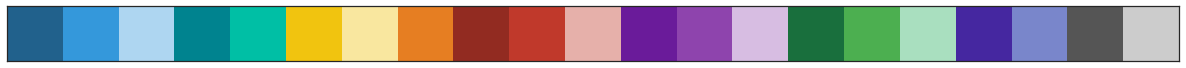

In [145]:

#format plots
sns.set(style='white', context='notebook', font_scale=1.5, 
        rc={'font.sans-serif': 'DejaVu Sans', 'lines.linewidth': 2.5})

#create a custom color palette
palette21 = ['#21618C', '#3498DB', '#AED6F1', '#00838F', '#00BFA5',
             '#F1C40F', '#F9E79F', '#E67E22', '#922B21', '#C0392B', 
             '#E6B0AA', '#6A1B9A', '#8E44AD', '#D7BDE2', '#196F3D', 
             '#4CAF50', '#A9DFBF', '#4527A0', '#7986CB', '#555555', 
             '#CCCCCC']
sns.palplot(palette21)

#create a color map
blog_blue = '#64C0C0'
blue_cmap = sns.light_palette(blog_blue, as_cmap=True)

# Load data and preprocess titles

In [146]:
tweets = pd.read_csv('tweets.csv', delimiter=';', nrows=10000, lineterminator='\n' )
tweets.head()

,id,user,fullname,url,timestamp,replies,likes,retweets,text
0,1132977055300300800,KamdemAbdiel,Abdiel kamdem,NaN,2019-05-27 11:49:14+00,0,0,0,È appena uscito un nuovo video! LES CRYPTOMONN...
1,1132977073402736640,bitcointe,Bitcointe,NaN,2019-05-27 11:49:18+00,0,0,0,Cardano: Digitize Currencies; EOS https://t.co...
2,1132977023893139456,3eyedbran,Bran - 3 Eyed Raven,NaN,2019-05-27 11:49:06+00,0,2,1,Another Test tweet that wasn't caught in the s...
3,1132977089089556481,DetroitCrypto,J. Scardina,NaN,2019-05-27 11:49:22+00,0,0,0,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
4,1132977092340191232,mmursaleen72,Muhammad Mursaleen,NaN,2019-05-27 11:49:23+00,0,0,0,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...


In [147]:
 # Rename columns
tweets.columns = ["id", "user", "fullname", "url", "timestamp", "replies","likes","retweets","text"]

In [148]:
tweets.head()

,id,user,fullname,url,timestamp,replies,likes,retweets,text
0,1132977055300300800,KamdemAbdiel,Abdiel kamdem,NaN,2019-05-27 11:49:14+00,0,0,0,È appena uscito un nuovo video! LES CRYPTOMONN...
1,1132977073402736640,bitcointe,Bitcointe,NaN,2019-05-27 11:49:18+00,0,0,0,Cardano: Digitize Currencies; EOS https://t.co...
2,1132977023893139456,3eyedbran,Bran - 3 Eyed Raven,NaN,2019-05-27 11:49:06+00,0,2,1,Another Test tweet that wasn't caught in the s...
3,1132977089089556481,DetroitCrypto,J. Scardina,NaN,2019-05-27 11:49:22+00,0,0,0,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
4,1132977092340191232,mmursaleen72,Muhammad Mursaleen,NaN,2019-05-27 11:49:23+00,0,0,0,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...


In [149]:
#preprocess words in title: split words, convert to lowercase, and remove punctuation
tweets['words'] = tweets['text'].apply(lambda x: x.lower().split())
tweets['words'] = tweets['words'].apply(lambda x: [word.strip(string.punctuation) for word in x])

In [150]:
tweets['date'] = pd.to_datetime(tweets['timestamp'],format= '%Y-%m-%d').dt.date

In [151]:
#add columns for year and month
tweets['year'] = tweets['date'].apply(lambda x: x.year)
tweets['month'] = tweets['date'].apply(lambda x: x.month)

In [152]:
tweets.head()

,id,user,fullname,url,timestamp,replies,likes,retweets,text,words,date,year,month
0,1132977055300300800,KamdemAbdiel,Abdiel kamdem,NaN,2019-05-27 11:49:14+00,0,0,0,È appena uscito un nuovo video! LES CRYPTOMONN...,"[è, appena, uscito, un, nuovo, video, les, cry...",2019-05-27,2019,5
1,1132977073402736640,bitcointe,Bitcointe,NaN,2019-05-27 11:49:18+00,0,0,0,Cardano: Digitize Currencies; EOS https://t.co...,"[cardano, digitize, currencies, eos, https://t...",2019-05-27,2019,5
2,1132977023893139456,3eyedbran,Bran - 3 Eyed Raven,NaN,2019-05-27 11:49:06+00,0,2,1,Another Test tweet that wasn't caught in the s...,"[another, test, tweet, that, wasn't, caught, i...",2019-05-27,2019,5
3,1132977089089556481,DetroitCrypto,J. Scardina,NaN,2019-05-27 11:49:22+00,0,0,0,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,"[current, crypto, prices, btc, 8721.99, usd, e...",2019-05-27,2019,5
4,1132977092340191232,mmursaleen72,Muhammad Mursaleen,NaN,2019-05-27 11:49:23+00,0,0,0,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,"[spiv, nosar, baz, bitcoin, is, an, asset, amp...",2019-05-27,2019,5


In [153]:
tweets = tweets[['words', 'date', 'year', 'month', 'timestamp']]


In [154]:
tweets.head()

,words,date,year,month,timestamp
0,"[è, appena, uscito, un, nuovo, video, les, cry...",2019-05-27,2019,5,2019-05-27 11:49:14+00
1,"[cardano, digitize, currencies, eos, https://t...",2019-05-27,2019,5,2019-05-27 11:49:18+00
2,"[another, test, tweet, that, wasn't, caught, i...",2019-05-27,2019,5,2019-05-27 11:49:06+00
3,"[current, crypto, prices, btc, 8721.99, usd, e...",2019-05-27,2019,5,2019-05-27 11:49:22+00
4,"[spiv, nosar, baz, bitcoin, is, an, asset, amp...",2019-05-27,2019,5,2019-05-27 11:49:23+00


In [155]:
#count all words in the tweets
word_counts = Counter(tweets['words'].apply(pd.Series).stack())
print('Number of unique words: ',len(word_counts))

Number of unique words:  37954


In [156]:
#remove words that appear fewer than X times
count_threshold = 50

for key, count in dropwhile(lambda x: x[1] >= count_threshold, word_counts.most_common()):
    del word_counts[key]
print('Number of unique words with at least',count_threshold,'occurances: ',len(word_counts))

Number of unique words with at least 50 occurances:  484


In [157]:
#create a list of unique words
unique_words = list(word_counts.keys())
unique_words[:10]

['un',
 'les',
 'bitcoin',
 'en',
 '2019',
 'eos',
 '',
 'ada',
 'cryptocurrency',
 'another']

In [158]:
#count the number of tweets published each month
d = tweets.groupby(['year','month'])['words'].count().reset_index(drop=True)
print(d)

0        1
1        1
2        1
3        1
4        2
5        1
6        1
7        1
8        1
9        2
10       2
11       3
12      13
13      58
14    9912
Name: words, dtype: int64


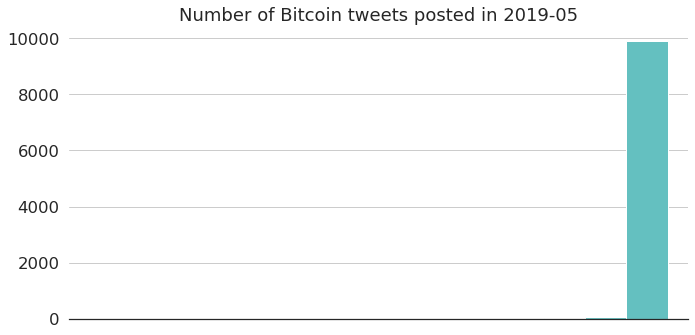

In [159]:
#plot the number of tweets posted each month

#initialize a figure
plt.figure(figsize=(10,5))

#plot bars
#axes = plt.bar(d.index, d, width=1, color=blue_cmap((d-np.min(d))/(np.max(d)-np.min(d)))) #color according to height
axes = plt.bar(d.index, d, width=1, color=blue_cmap(d.index.values/d.index.max()))  #color according to month

#format plot
plt.grid(axis='y')
plt.xlim(0,len(d))
plt.xticks(range(0,len(d),24), range(2019,2019,5), rotation='vertical')
plt.tick_params(axis='x', length=5)
plt.title('Number of Bitcoin tweets posted in 2019-05')
sns.despine(left=True)

plt.tight_layout()
plt.savefig('bitcoin_tweets_over_time.png', dpi=300)

In [160]:
all_r = pd.DataFrame(columns=unique_words, index=d.index)

for i, word in enumerate(unique_words):
    
    all_r[word] = pd.concat([tweets.loc[:,['year','month']], 
                             tweets['words'].apply(lambda x: word in x)], 
                            axis=1) \
                    .groupby(by=['year','month']) \
                    .sum() \
                    .reset_index(drop=True)
                
    #print out a status indicator
    if np.mod(i,100)==0:
        print('word',i,'complete')
    
all_r

word 0 complete
word 100 complete
word 200 complete
word 300 complete
word 400 complete


,un,les,bitcoin,en,2019,eos,,ada,cryptocurrency,another,...,wallets,hackers,abra,ban,incoming,realdonaldtrump,hack,detect,caerus,investigating
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
def plot_most_common_words(word_counts, n, title, gradient, label_type):
    
    #filter stop words
    discard_words = ['of','in','and','the','a','with','for','to','on','an','by','using',
                     'from','as','is','at','between','during', 'you', 'this'
                     'now','will','that','are','your','it']
    for key in discard_words:
        del word_counts[key]
    word_counts = pd.DataFrame(word_counts.most_common()[:n], columns=['word','count'])

    #define colors for bars
    if gradient:
        bar_colors = blue_cmap((word_counts['count'])/(word_counts['count'].max()))
    else:
        bar_colors = blog_blue

    #create a horizontal bar plot
    plt.barh(range(n,0,-1), word_counts['count'], height=0.85, color=bar_colors, alpha=1)

    #format plot
    sns.despine(left=True,bottom=True)
    plt.ylim(0,n+1)
    plt.title(title)
    plt.grid(axis='x')

    #label bars
    if label_type == 'counts':
        plt.yticks(range(n,0,-1), word_counts['word']);
        for i, row in word_counts.iterrows():
            plt.text(row['count']-100,50-i-0.2, row['count'], horizontalalignment='right', fontsize='12', color='white')

    elif label_type == 'labeled_bars_left':
        plt.yticks(range(n,0,-1), []);
        for i, row in word_counts.iterrows():
            plt.text(50,n-i-0.2, row['word'], horizontalalignment='left', fontsize='14')

    elif label_type == 'labeled_bars_right':
        plt.yticks(range(n,0,-1), []);
        for i, row in word_counts.iterrows():
            plt.text(row['count'],n-i-0.2,row['word'], horizontalalignment='right', fontsize='14')

    else:
        plt.yticks(range(n,0,-1), word_counts['word']);

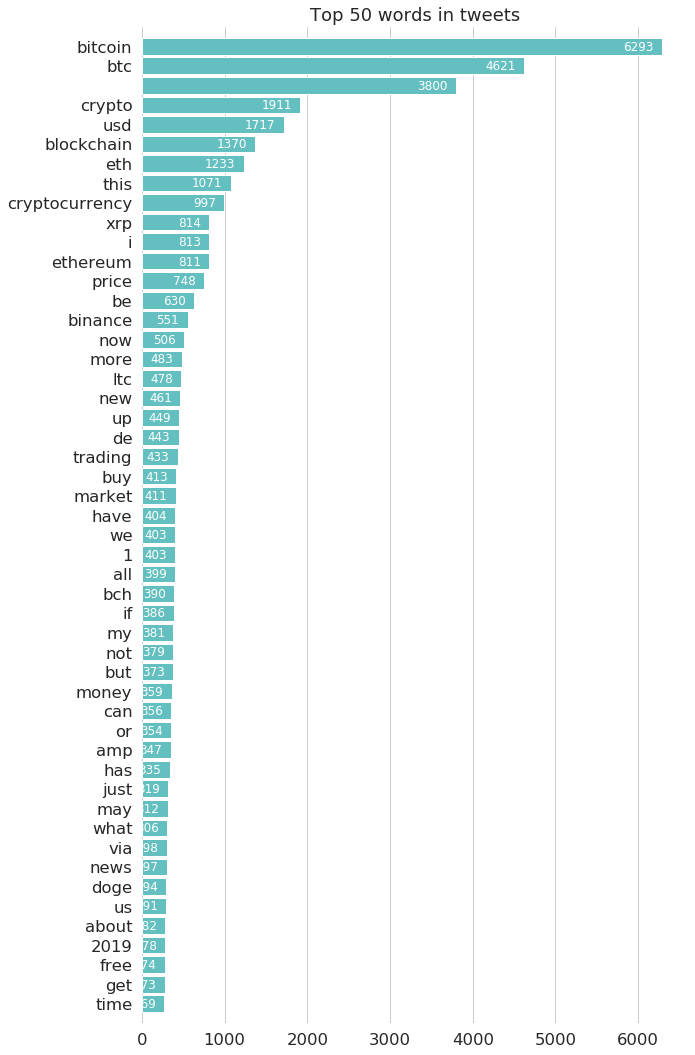

In [162]:
plt.figure(figsize=(10,15))
plot_most_common_words(word_counts=word_counts, n=50, 
                       title='Top 50 words in tweets', 
                       gradient=False, label_type='counts')
plt.tight_layout()
plt.savefig('most_common_words_in_tweets.png',dpi=300)

# Find bursts for each unique word

In [168]:
#find bursts

#create a dataframe to hold results
all_bursts = pd.DataFrame(columns=['begin','end','weight'])

#define variables
s = 2         #resolution of state jumps; higher s --> fewer but stronger bursts
gam = 0.5     #difficulty of moving up a state; larger gamma --> harder to move up states, less bursty
n = len(d)    #number of timepoints

#loop through unique words
for i, word in enumerate(unique_words):

    r = all_r.loc[:,word].astype(int)

    #find the optimal state sequence (using the Viterbi algorithm)
    [q, _, _, p] = bd.burst_detection(r,d,n,s,gam,smooth_win=5)

    #enumerate the bursts
    bursts = bd.enumerate_bursts(q, word)

    #find weight of each burst
    bursts = bd.burst_weights(bursts, r, d, p)
    #add the bursts to a list of all bursts
    all_bursts = all_bursts.append(bursts, ignore_index=True)
    
    #print a progress report every 100 words
    if np.mod(i,100)==0:
        print('word',i,'complete')

all_bursts.sort_values(by='weight', ascending=False)
#scroll down the warning to see the bursts of each word

C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:97: RuntimeWarning: invalid value encountered in greater
  if (burst==False) & (q[t] > q[t-1]):
C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:101: RuntimeWarning: invalid value encountered in less
  if (burst==True) & (q[t] < q[t-1]):
C:\Users\kavit\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:97: RuntimeWarning: invalid value encountered in greater
  if (burst==False) & (q[t] > q[t-1]):
C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:101: RuntimeWarning: invalid value encountered in less
  if (burst==

word 0 complete


C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:101: RuntimeWarning: invalid value encountered in less
  if (burst==True) & (q[t] < q[t-1]):
C:\Users\kavit\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:97: RuntimeWarning: invalid value encountered in greater
  if (burst==False) & (q[t] > q[t-1]):
C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:101: RuntimeWarning: invalid value encountered in less
  if (burst==True) & (q[t] < q[t-1]):
C:\Users\kavit\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A futur

word 100 complete


C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:101: RuntimeWarning: invalid value encountered in less
  if (burst==True) & (q[t] < q[t-1]):
C:\Users\kavit\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:97: RuntimeWarning: invalid value encountered in greater
  if (burst==False) & (q[t] > q[t-1]):
C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:101: RuntimeWarning: invalid value encountered in less
  if (burst==True) & (q[t] < q[t-1]):
C:\Users\kavit\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A futur

word 200 complete


C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:101: RuntimeWarning: invalid value encountered in less
  if (burst==True) & (q[t] < q[t-1]):
C:\Users\kavit\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:97: RuntimeWarning: invalid value encountered in greater
  if (burst==False) & (q[t] > q[t-1]):
C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:101: RuntimeWarning: invalid value encountered in less
  if (burst==True) & (q[t] < q[t-1]):
C:\Users\kavit\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A futur

word 300 complete


C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:97: RuntimeWarning: invalid value encountered in greater
  if (burst==False) & (q[t] > q[t-1]):
C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:101: RuntimeWarning: invalid value encountered in less
  if (burst==True) & (q[t] < q[t-1]):
C:\Users\kavit\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:97: RuntimeWarning: invalid value encountered in greater
  if (burst==False) & (q[t] > q[t-1]):
C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:101: RuntimeWarning: invalid value encountered in less
  if (burst==

word 400 complete


C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:101: RuntimeWarning: invalid value encountered in less
  if (burst==True) & (q[t] < q[t-1]):
C:\Users\kavit\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:97: RuntimeWarning: invalid value encountered in greater
  if (burst==False) & (q[t] > q[t-1]):
C:\Users\kavit\Downloads\burst_detection-master\burst_detection\__init__.py:101: RuntimeWarning: invalid value encountered in less
  if (burst==True) & (q[t] < q[t-1]):
C:\Users\kavit\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A futur

,begin,end,label,weight
1,12,14,crypto,24.9221
6,12,14,to,18.6766
8,12,14,blockchain,15.2127
0,12,14,,15.1969
20,12,14,up,12.4409
21,12,14,🚀,11.7568
16,12,14,1,11.7534
10,12,14,airdrop,11.7525
13,12,14,new,11.0653
12,12,14,by,10.3759
